##### Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

# 1=188, 2=376, 3=376, 4=376, 5=376, 6=376, 7=192, 8=192

# IMPORTS

In [1]:
import os
import librosa
import numpy as np
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from collections import Counter
import matplotlib.pyplot as plt


# CUSTOM DATASET

In [2]:
class CustomAudioDataset(Dataset):
    def __init__(self, base_path, sr=22050, n_mels=128, augment=False):
        self.base_path = base_path
        self.sr = sr
        self.n_mels = n_mels
        self.augment = augment

        self.audio_file_paths = []
        self.labels = []
        
        for subfolder in os.scandir(base_path):
            if subfolder.is_dir():
                for actor_dir in os.scandir(subfolder):
                    if actor_dir.is_dir():
                        for file in os.scandir(actor_dir.path):
                            if file.is_file() and file.name.endswith('.wav'):
                                try:
                                    label = int(file.name.split('-')[2][1]) - 1
                                    self.audio_file_paths.append(file.path)
                                    self.labels.append(label)
                                except (ValueError, IndexError):
                                    continue
    
    def __len__(self):
        return len(self.audio_file_paths)

    def apply_augmentation(self, y):
        # pitch shift
        if random.random() < 0.3:
            y = librosa.effects.pitch_shift(y, sr=self.sr, n_steps=random.uniform(-2, 2))
        # time stretch
        if random.random() < 0.3:
            rate = random.uniform(0.9, 1.1)
            y_fast = librosa.resample(y, orig_sr=self.sr, target_sr=int(self.sr * rate))
            if len(y_fast) > 0:
                y = librosa.resample(y_fast, orig_sr=int(self.sr * rate), target_sr=self.sr)
        # noise
        if random.random() < 0.3:
            noise_amp = 0.005 * np.random.uniform() * np.amax(y)
            y += noise_amp * np.random.normal(size=y.shape)
        return y

    def __getitem__(self, idx):
        target_length = int(3.6 * self.sr)
        y, sr = librosa.load(self.audio_file_paths[idx], sr=self.sr)

        if self.augment:
            y = self.apply_augmentation(y)

        if len(y) < target_length:
            pad_total = target_length - len(y)
            y = np.pad(y, (pad_total // 2, pad_total - pad_total // 2))
        else:
            start = (len(y) - target_length) // 2
            y = y[start:start + target_length]

        # Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels, n_fft=1024, hop_length=512)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        log_mel_spec = (log_mel_spec - np.mean(log_mel_spec)) / (np.std(log_mel_spec) + 1e-8)

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=self.n_mels, n_fft=1024, hop_length=512)
        mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-8)

        stacked_spec = np.stack([log_mel_spec, mfcc])
        tensor_spec = torch.tensor(stacked_spec, dtype=torch.float32)
        label = self.labels[idx]
        return tensor_spec, label


In [3]:
batch_size = 64
data_path="/kaggle/input/audio-aiml-mars" # path of directory

In [4]:
dataset = CustomAudioDataset(data_path,
        sr=22050,   # or 16000 
        n_mels=128,
        )

In [5]:
dataset[0][0].shape

torch.Size([2, 128, 156])

# DATA LOADING

In [6]:
# checking number of samples loaded per class
from collections import Counter
class_counts = Counter(dataset.labels)
for class_label, count in sorted(class_counts.items()):
    print(f"Class {class_label}: {count} samples")

Class 0: 188 samples
Class 1: 376 samples
Class 2: 376 samples
Class 3: 376 samples
Class 4: 376 samples
Class 5: 376 samples
Class 6: 192 samples
Class 7: 192 samples


In [8]:
# stratified spliting
labels = dataset.labels
indices = list(range(len(dataset)))

train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2, # 20% evaluation data
    stratify=labels,
    random_state=42
)
train_set = Subset(CustomAudioDataset(data_path, augment=True), train_indices)
test_set = Subset(CustomAudioDataset(data_path, augment=False), test_indices)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [9]:
# checking number of samples loaded as training and evaluation data

train_labels = [dataset.labels[i] for i in train_indices]
test_labels = [dataset.labels[i] for i in test_indices]

train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)

print("🔹 Train Set Class Distribution:")
for label, count in sorted(train_class_counts.items()):
    print(f"Class {label}: {count} samples")

print("\n🔹 Test Set Class Distribution:")
for label, count in sorted(test_class_counts.items()):
    print(f"Class {label}: {count} samples")


🔹 Train Set Class Distribution:
Class 0: 150 samples
Class 1: 301 samples
Class 2: 301 samples
Class 3: 301 samples
Class 4: 301 samples
Class 5: 301 samples
Class 6: 153 samples
Class 7: 153 samples

🔹 Test Set Class Distribution:
Class 0: 38 samples
Class 1: 75 samples
Class 2: 75 samples
Class 3: 75 samples
Class 4: 75 samples
Class 5: 75 samples
Class 6: 39 samples
Class 7: 39 samples


In [10]:
# shape check 
data_iter = iter(train_loader)
inputs, labels = next(data_iter)

print(inputs.shape)  # tensor shape of batch
print(labels.shape)  # tensor shape of batch labels


torch.Size([64, 2, 128, 156])
torch.Size([64])


# MODEL

MEL SPECTROGRAM + MFCC

In [11]:
class DeepAudioEmotionCNN(nn.Module):
    def __init__(self, num_classes=8, dropout_rate=0.3):
        super(DeepAudioEmotionCNN, self).__init__()
        
        self.conv_blocks = nn.Sequential(
            self._make_conv_block(2, 64, dropout_rate),
            self._make_conv_block(64, 128, dropout_rate),
            self._make_conv_block(128, 256, dropout_rate),
            self._make_conv_block(256, 512, dropout_rate),
            self._make_conv_block(512, 512, dropout_rate),
        )
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #dense layers
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
        
    def _make_conv_block(self, in_channels, out_channels, dropout_rate):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout_rate)
        )
    
    def forward(self, x):
        x = self.conv_blocks(x)
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

# Training

In [14]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=20):
    train_losses, val_losses, val_accuracies = [], [], []
    best_val=0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            print(".",end="")

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        scheduler.step(val_loss)
        if val_acc> best_val:
            best_val = val_acc
            torch.save(model.state_dict(), '/kaggle/working/model.pth') # saves the new best model
        print("Current LR:", scheduler.get_last_lr())
        print(f"Epoch {epoch+1}/{epochs} — Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, val_accuracies


In [27]:
def plot_confusion_matrix_and_metrics(true_labels, predicted_labels, class_names):
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Per-class accuracy
    print("\n📊 Per-Class Accuracy:")
    cm_sum = cm.sum(axis=1)
    class_acc = cm.diagonal() / cm_sum
    for i, acc in enumerate(class_acc):
        print(f"{class_names[i]}: {acc:.2%}")


    macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(true_labels, predicted_labels, average='weighted')
    overall_acc = accuracy_score(true_labels, predicted_labels)

    print(f"✅ Overall Accuracy: {overall_acc:.2%}")
    print(f"🎯 Macro F1 Score: {macro_f1:.4f}")
    print(f"🎯 Weighted F1 Score: {weighted_f1:.4f}")



def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


...............................Current LR: [0.0005]
Epoch 1/100 — Train Loss: 1.9462 | Val Loss: 1.8924 | Val Acc: 0.1527
...............................Current LR: [0.0005]
Epoch 2/100 — Train Loss: 1.8977 | Val Loss: 1.8517 | Val Acc: 0.1527
...............................Current LR: [0.0005]
Epoch 3/100 — Train Loss: 1.8736 | Val Loss: 1.9025 | Val Acc: 0.2077
...............................Current LR: [0.0005]
Epoch 4/100 — Train Loss: 1.8028 | Val Loss: 1.8384 | Val Acc: 0.2179
...............................Current LR: [0.0005]
Epoch 5/100 — Train Loss: 1.7814 | Val Loss: 1.7129 | Val Acc: 0.2261
...............................Current LR: [0.0005]
Epoch 6/100 — Train Loss: 1.7249 | Val Loss: 1.6414 | Val Acc: 0.2912
...............................Current LR: [0.0005]
Epoch 7/100 — Train Loss: 1.7150 | Val Loss: 1.6834 | Val Acc: 0.3035
...............................Current LR: [0.0005]
Epoch 8/100 — Train Loss: 1.6899 | Val Loss: 1.5765 | Val Acc: 0.3340
........................

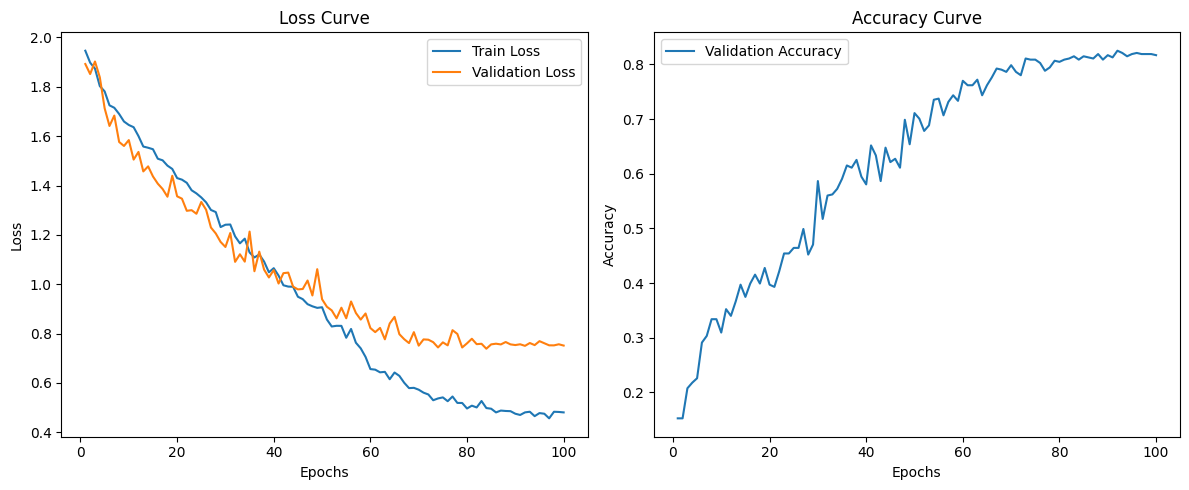

'\nbatch 16\nnew model\ntrain 0.000\n'

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepAudioEmotionCNN(8).to(device) 


# assigning weights
weights = torch.tensor([1.3, 1.0, 2.0, 3.5, 1.0, 1.5, 2.0, 1.0], dtype=torch.float32)
weights = weights.to(device)

criterion = nn.CrossEntropyLoss(weight= weights, label_smoothing=0.05)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


train_losses, val_losses, val_accuracies = train(
    model, train_loader, test_loader, criterion, optimizer, device, epochs=100
)

# Plot metrics
plot_metrics(train_losses, val_losses, val_accuracies)

"""
batch 64
new model
train 0.0005
audio lenth 0.6
smooth labeling 0.05
weights [1.3, 1.0, 2.0, 3.5, 1.0, 1.5, 2.0, 1.0]
"""

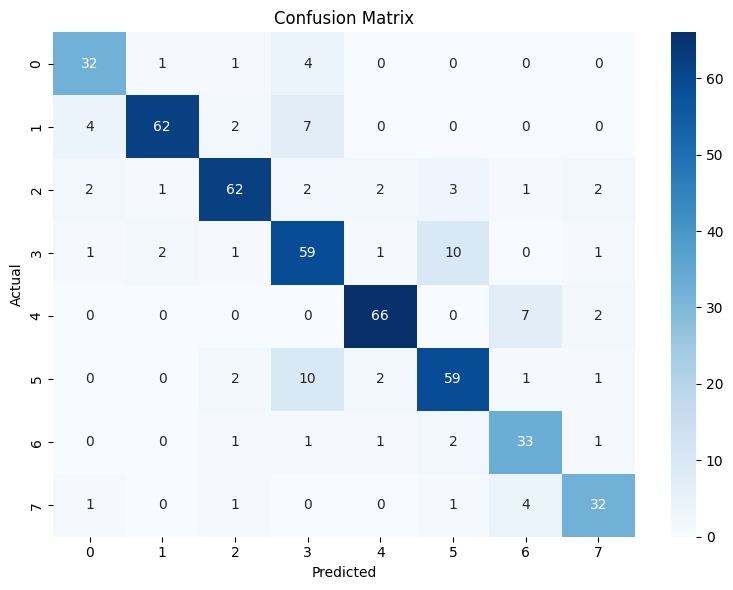


📊 Per-Class Accuracy:
0: 84.21%
1: 82.67%
2: 82.67%
3: 78.67%
4: 88.00%
5: 78.67%
6: 84.62%
7: 82.05%
✅ Overall Accuracy: 82.48%
🎯 Macro F1 Score: 0.8229
🎯 Weighted F1 Score: 0.8267


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ = DeepAudioEmotionCNN(num_classes=8).to(device)

state_dict = torch.load('/kaggle/working/model.pth')
model_.load_state_dict(state_dict)

model_.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot matrix
plot_confusion_matrix_and_metrics(all_labels, all_preds, class_names=[str(i) for i in range(8)]) 
